# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, cross_validate
import statistics
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import classification_report, RocCurveDisplay
from joblib import dump, load

# Preprocessing

In [3]:
# Einlesen der Daten
df = pd.read_csv("train.csv")

# Spalte Index nicht aussagekräftig --> Wird gelöscht
df = df.drop(columns="index")

# Operationen auf Datumsspalte:
# Anlegen der Spalte Tag und Uhrzeit und Löschen von "Datum", da es nicht sinnführend bei Operationen ist
df["Datum"]=pd.to_datetime(df["Datum"])
df["Tag"]=df["Datum"].dt.day.astype(str)
df["Uhrzeit"]=df["Datum"].dt.hour.astype(str)
df_modified = df.drop(columns="Datum",axis=1)

# Skalierung von CO2, da rechtsschiefe Verteilung 
# und von allen anderen, da SVM sensitiv auf Skalierung reagiert
scaler= MinMaxScaler()
df_modified[["Temperatur","Luftfeuchtigkeit","CO2","Wassergehalt","Tag","Uhrzeit"]]=scaler.fit_transform(df_modified[["Temperatur","Luftfeuchtigkeit","CO2","Wassergehalt","Tag","Uhrzeit"]])

# Auffüllen NaN-Werte mit vorherigem Wert in der Spalte (forward fill)
df_modified.fillna(method="ffill", inplace= True)


# Teile Daten in Features und Label auf
X = df_modified.drop(columns=["Anwesenheit"])
y = df_modified[["Anwesenheit"]]

# Wird benötigt, um richtige Shape zu haben für späteres Vorgehen
y = np.ravel(y)


# Training auf Ausschnitt des Datensatzes

## SMOTE notwendig ? Grobe Orientierung der Hyperparameter?

In [4]:
# Training auf 10 % des Datensatzes, da Laufzeit sonst zu lange
df_sampled = df_modified.sample(frac=0.1)

# Teile Daten in Features und Label auf
X_sampled = df_sampled.drop(columns=["Anwesenheit"],axis=1)
y_sampled = df_sampled[["Anwesenheit"]]

# Wieder in richtige Shape für später bringen
y_sampled = np.ravel(y_sampled)

In [5]:
# Training und Testset der sampled data 
# Auf Trainingsset wird CV und Training angewandt, auf Testset wird dann überprüft
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

In [ ]:
# GridSearch ohne SMOTE zur Bestimmung der Parameter, welche den höchsten Recall vorbringen

# Auswahlmöglichkeit an möglichen Kombinationen der Parameter, blinde Auswahl
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [0.1, 1], "C": [1, 10]},
    {"kernel": ["linear"], "C": [1, 10]},
    {"kernel": ["poly"],"C": [1, 10]}
]

# Nun: GridSearchCV, sucht mittels CV und eben GridSearch die Kombination der Parameter, welche den höchsten Recall vorbringt
# Gehe hauptsächlich auf Recall, da keine MA frieren sollen
clf_sampled = GridSearchCV(SVC(), tuned_parameters, scoring="recall")

# Fitten der SVC auf den Trainingsdaten der sampled data
clf_sampled.fit(X_s_train, y_s_train)

# Ausgabe der Parameter, welche den höchsten Recall erzeugen
best_parameters_sampled = clf_sampled.best_params_
print(best_parameters_sampled)

# Ausgabe des besten Recall-Ergebnisses
best_result = clf_sampled.best_score_
print(best_result)

# Vorhersage auf Testset
y_s_true, y_s_pred = y_s_test, clf_sampled.predict(X_s_test)

# Ausgabe eines Classification Reports, zeigt Performance auf Testset
print(classification_report(y_s_true, y_s_pred))

In [22]:
# GridSearch mit vorherigem SMOTE
# SMOTE wird angewandt, da eine ungleich große Verteilung der Daten vorliegt
# Habe dreimal so viele Datenpunkte, in welchen Anwesenheit = 0 ist, als Anwesenheit =1
# Deswegen: Auswahl einer Oversampling-Strategie, hierbei Entscheidung für SMOTE anstatt für Verdreifachen der Datenpunkte mit Anwesenheit = 1

# Geht irgendwie nicht, wenn es explizit definiert wird, also Definition im Nachfolgenden
# SMOTE = SMOTE()

# Transformation wird auf Sampled Data angewandt
X_s_train_SMOTE, y_s_train_SMOTE = SMOTE().fit_resample(X_s_train, y_s_train)

# Willkürliche Auswahl an möglichen Kombinationen, wie oben
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [0.1, 1], "C": [1, 10]},
    {"kernel": ["linear"], "C": [1, 10]},
    {"kernel": ["poly"],"C": [1, 10]}
]


# Gehe hauptsächlich auf Recall, da keine MA frieren sollen
# GridSearchCV, um die besten Hyperparameter zu finden, wodurch Recall maximal ist
clf_SMOTE_sampled = GridSearchCV(SVC(), tuned_parameters, scoring="recall")

# Trainiere SVM
clf_SMOTE_sampled.fit(X_s_train_SMOTE, y_s_train_SMOTE)

# Ausgabe der Parameter, mit denen Recall am höchsten ist
best_parameters_sampled_SMOTE = clf_SMOTE_sampled.best_params_
print(best_parameters_sampled_SMOTE)

best_result_SMOTE = clf_SMOTE_sampled.best_score_
print(best_result_SMOTE)

y_s_true_SMOTE, y_s_pred_SMOTE = y_s_test, clf_SMOTE_sampled.predict(X_s_test)
print(classification_report(y_s_true_SMOTE, y_s_pred_SMOTE))

# Mit SMOTE: Bekomme besseres Ergebnis als ohne!
# Resultat: SMOTE muss auf ganzem Datensatz angewandt werden.

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.9719502243982048
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       216
           1       0.83      0.93      0.88        69

    accuracy                           0.94       285
   macro avg       0.90      0.93      0.92       285
weighted avg       0.94      0.94      0.94       285



# Training auf ganzem Datensatz 

## Split in Trainings- und Testset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Oversampling behandeln mit SMOTE

In [7]:
# SMOTE, um ungleiche Verteilung der Datenpunkte auszugleichen
SMOTE = SMOTE()

# Transformieren der Trainingsdaten mit SMOTE
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

# Sehen, was Ergebnis ist
print("After oversampling: ",Counter(y_train_SMOTE))

After oversampling:  Counter({1: 8472, 0: 8472})


### Hyperparameter Suche mit exhaustive GridSearchCV - rein auf recall fokussiert

In [25]:
# Nun: Hyperparametersuche, beeinflusst durch obrige Ergebnisse und intensivere Betrachtung von Kernel rbf
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [0.1,0.5, 1], "C": [1, 10,100,1000]},
    #{"kernel": ["linear"], "C": [1, 10]},
    #{"kernel": ["poly"],"C": [1, 10]}
]


# Suchen der Parameter, mit denen Recall maximal wird
clf_SMOTE = GridSearchCV(SVC(), tuned_parameters, scoring="recall")

# Anwenden auf Modell
clf_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)

# Ausgabe der Parameter, mit denen Recall maximal wird
best_parameters = clf_SMOTE.best_params_
print(best_parameters)

# Recall Wert für die ausgesuchte Parameterkombination ausgeben
best_result = clf_SMOTE.best_score_
print(best_result)

# Predictions
y_true, y_pred = y_test, clf_SMOTE.predict(X_test)

# Performance auf Testset
print(classification_report(y_true, y_pred))

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
0.9893773268833608
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2116
           1       0.92      0.99      0.96       733

    accuracy                           0.98      2849
   macro avg       0.96      0.98      0.97      2849
weighted avg       0.98      0.98      0.98      2849



In [ ]:
# Speichern des Modells, da es sehr lange geladen hat
dump(clf_SMOTE, 'svm.joblib') 

## ROC Kurve 

In [8]:
# Nutzen des Modells
clf_SMOTE = load('svm.joblib') 

In [9]:
# Training des Modells mit den herausgefundenen Parametern
# probability = True, da sonst später predict_proba() nicht funktioniert

clf_best = SVC(C=1000, gamma=1,kernel="rbf", probability=True)
clf_best.fit(X_train_SMOTE, y_train_SMOTE)
y_pred_best = clf_best.predict(X_test)

In [29]:
dump(clf_best,'final_svc.joblib')

['final_svc.joblib']

In [10]:
clf_best = load('final_svc.joblib') 

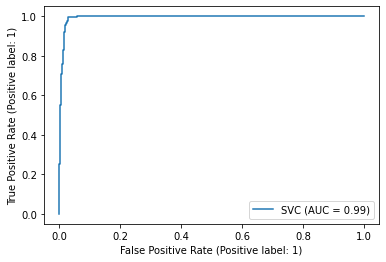

In [29]:
RocCurveDisplay.from_estimator(clf_best, X_test, y_test)

# Vorhersage auf test.csv

## Reproduktion aller Schritte zum Vorbereiten der Daten

In [4]:
df_raw = pd.read_csv("test.csv")

def data_prep(df_raw):
    
    df_raw = df_raw.drop(columns="index")
    df_raw["Datum"]=pd.to_datetime(df_raw["Datum"])
    df_raw["Tag"]=df_raw["Datum"].dt.day.astype(str)
    df_raw["Uhrzeit"]=df_raw["Datum"].dt.hour.astype(str)
    df_raw = df_raw.drop(columns="Datum",axis=1)
    scaler= MinMaxScaler()
    df_raw[["Temperatur","Luftfeuchtigkeit","CO2","Wassergehalt","Tag","Uhrzeit"]]=scaler.fit_transform(df_raw[["Temperatur","Luftfeuchtigkeit","CO2","Wassergehalt","Tag","Uhrzeit"]])
    df_raw.fillna(method="ffill", inplace= True)
    df_prepared = df_raw
    return df_prepared

df_prepared = data_prep(df_raw)

## Vorhersage

In [5]:
test_pred = clf_SMOTE.predict(df_test)
df_pred = pd.DataFrame(test_pred)
df_pred = df_pred.rename(columns={0:"Vorhergesagte_Anwesenheit"})
df_pred

NameError: name 'clf_SMOTE' is not defined

# Vorhersagen auf Validation-Set des ganzen Datensatzes für ROC-Kurve zum Vergleich der vier Methodne

In [77]:
probs = clf_best.predict_proba(X_test)
preds = []
for threshold in np.arange(0, 1.01, 0.01):
    preds.append(probs > threshold)

In [80]:
calc = pd.DataFrame(index=np.arange(0,2849,1))

for index, element in enumerate(preds):
    calc[index] = pd.DataFrame(element).drop(0, axis=1).astype(int)

calc['Anwesenheit'] = y_test
calc = calc.astype(bool)

/var/folders/0y/smycr6594jxd0n8scvb22wph0000gn/T/ipykernel_94806/214487222.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  calc[index] = pd.DataFrame(element).drop(0, axis=1).astype(int)
/var/folders/0y/smycr6594jxd0n8scvb22wph0000gn/T/ipykernel_94806/214487222.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  calc['Anwesenheit'] = y_test


In [81]:
calc

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,Anwesenheit
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2844,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2845,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2846,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2847,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,True


In [82]:
confusion_matrix(y_true = calc['Anwesenheit'], y_pred = y_pred_best)

array([[2053,   63],
       [   4,  729]])

In [83]:
l = []
for element in np.arange(0,101,1):
    tn, fp, fn, tp = confusion_matrix(y_true=calc['Anwesenheit'],y_pred=calc[element]).ravel()
    tpr = tp / (tp+fn)
    fpr = fp / (fp+tn)
    tup = np.array([tpr,fpr])
    l.append(tup)
    
rates_ = pd.DataFrame(l, columns = ['TPR','FPR'])
rates_['Threshold'] = np.arange(0,1.01,0.01)

In [84]:
rates_.to_csv("roc_values_SVC.csv", index=False)